In [6]:
import os
import csv
import pandas as pd
import numpy as np

In [7]:
input_data_dir = '/Users/simon/Dropbox/TP pairs/'
pairs_file = 'PairsTableSI-1_TrueOnly.xlsx'

In [8]:
df = pd.read_excel(os.path.join(input_data_dir,pairs_file))

In [9]:
df.head()

,TP_ID,par_ID,Transformation_Product,Parent_compound,Type,TP_CAS,TP_logDph7,TP_SMILES,TP_formula,TP_MZ,par_CAS,par_logDph7,par_SMILES,par_formula,par_MZ,Ionization,Mass_Diff,Form_Diff,TanimotoDissimilarity,Transformation
0,249,185,N4-Acetyl-Sulfathiazol,Sulfathiazol,True pair,127-76-4,0.686881,CC(=O)NC1=CC=C(C=C1)S(=O)(=O)NC1=NC=CS1,C11H11N3O3S2,297.0242,127-76-4,0.691542,NC1=CC=C(C=C1)S(=O)(=O)NC1=NC=CS1,C9H9N3O2S2,255.0136,positive,42.0106,C2H2O1,0.287234,acetylation
1,236,702,4-Acetamidoantipyrin (=N-Acetyl-4-Aminoantipyr...,Aminopyrine,True pair,83-15-8,0.153812,CN1N(C(=O)C(NC(C)=O)=C1C)C1=CC=CC=C1,C13H15N3O2,245.1164,83-15-8,1.150468,CN(C)C1=C(C)N(C)N(C1=O)C1=CC=CC=C1,C13H17N3O,231.1372,positive,13.9792,H-2O1,0.283019,multiple
2,245,183,N4-Acetyl-Sulfadimethoxin,Sulfadimethoxin,True pair,24341-30-8,0.998810,COC1=CC(OC)=NC(NS(=O)(=O)C2=CC=C(NC(C)=O)C=C2)=N1,C14H16N4O5S,352.0841,83-15-8,0.967458,COC1=CC(NS(=O)(=O)C2=CC=C(N)C=C2)=NC(OC)=N1,C12H14N4O4S,310.0736,positive,42.0105,C2H2O1,0.283388,acetylation
3,247,181,N4-Acetyl-Sulfamethazin,Sulfamethazin,True pair,100-90-3,0.414393,CC(=O)NC1=CC=C(C=C1)S(=O)(=O)NC1=NC(C)=CC(C)=N1,C14H16N4O3S,320.0943,117-96-4,0.393304,CC1=CC(C)=NC(NS(=O)(=O)C2=CC=C(N)C=C2)=N1,C12H14N4O2S,278.0837,positive,42.0106,C2H2O1,0.250996,acetylation
4,248,179,N4-Acetyl-Sulfadiazin,Sulfadiazin,True pair,127-74-2,0.150364,CC(=O)NC1=CC=C(C=C1)S(=O)(=O)NC1=NC=CC=N1,C12H12N4O3S,292.0630,78649-41-9,0.129100,NC1=CC=C(C=C1)S(=O)(=O)NC1=NC=CC=N1,C10H10N4O2S,250.0524,positive,42.0106,C2H2O1,0.274038,acetylation


In [11]:
print(len(df['Parent_compound'].unique()))
print(len(df['par_SMILES'].unique()))
print(len(df['par_ID'].unique()))

150
148
146


In [19]:
par_dict = {p:set() for p in df['par_ID'].unique()}
for i,p in enumerate(df['par_ID']):
    tup = (df['par_SMILES'][i],df['Parent_compound'][i])
    par_dict[p].add(tup)
    
for p,vals in par_dict.items():
    if len(vals) > 1:
        print(p,vals)

288 {('CCNC1=NC(NC(C)C)=NC(Cl)=N1', 'Atrazine'), ('CCNC1=NC(NC(C)C)=NC(Cl)=N1', 'Atrazin')}
262 {('CCNC1=NC(NCC)=NC(Cl)=N1', 'Simazin'), ('c1(nc(nc(n1)Cl)NCC)NCC', 'Simazine')}
284 {('CCNC1=NC(NC(C)(C)C)=NC(Cl)=N1', 'Terbutylazine'), ('CCNC1=NC(NC(C)(C)C)=NC(Cl)=N1', 'Terbutylazin')}
645 {('COC1=CC=C(C=C1)C(CN(C)C)C1(O)CCCCC1', 'Venlafaxine'), ('COC1=CC=C(C=C1)C(CN(C)C)C1(O)CCCCC1', 'Venlafaxin')}
2772 {('N1([C@@H](c2ccc(Cl)cc2)c2ccccc2)CCN(CCOCC(O)=O)CC1', 'Cetirizine'), ('C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl', 'Cetirizine')}


# Code for importing and merging spectra

In [76]:
# grab all csv files
import glob
csv_files = glob.glob(os.path.join(input_data_dir,'*_pH*.csv'))
print(csv_files)

['/Users/simon/Dropbox/TP pairs/QExPlus_Xmas2014_pH_tx.csv', '/Users/simon/Dropbox/TP pairs/20140108_OrbiXL_pH_tx.csv', '/Users/simon/Dropbox/TP pairs/20140108_QEx_pH_tx.csv', '/Users/simon/Dropbox/TP pairs/20140108_QEx2_pH_tx.csv']


In [100]:
# method to put the spec into a dict.
# peak_delta_mz is set as per the paper.
# merging: the intensity is the max of the two to be merged. Using either the absolute or relative values
# (set absolute_intensity = False to use relative)
# Note that the resulting spectra are not normalised
def csv2spec(csv_file,peak_delta_mz = 0.001,absolute_intensity = True):
    specs = {}
    if absolute_intensity:
        intensity_pos = 3
    else:
        intensity_pos = 4
    with open(csv_file,'r') as f:
        reader = csv.reader(f)
        heads = next(reader)
#         print(heads)
        for line in reader:
            if line[20] == 'CID':
                continue
            peak_tuple = [float(line[2]),float(line[intensity_pos])]
            spec_id = int(line[1])
            if not spec_id in specs:
                specs[spec_id] = {}
                for i,h in enumerate(heads[11:]):
                    specs[spec_id][h] = line[11+i]
                specs[spec_id]['peaks'] = []
                specs[spec_id]['peaks'].append(peak_tuple)
                ce = specs[spec_id]['CollisionEnergy']
                specs[spec_id]['CollisionEnergy'] = [int(ce)] # make a list, and append energies as we merge
                specs[spec_id]['SourceFile'] = csv_file
            else:
                energy = int(line[21])
                if not energy in specs[spec_id]['CollisionEnergy']:
                    specs[spec_id]['CollisionEnergy'].append(energy)
                temp = np.array(specs[spec_id]['peaks'])
                pos = np.nonzero((peak_tuple[0] > temp[:,0] - peak_delta_mz)*(peak_tuple[0]<temp[:,0] + peak_delta_mz))[0]
                if len(pos) == 0:
                    specs[spec_id]['peaks'].append(peak_tuple)
                else:
                    pos = pos[0]
#                     print("Merging {} with {}".format(peak_tuple[0],specs[spec_id]['peaks'][pos][0]))
                    specs[spec_id]['peaks'][pos][1] = max(specs[spec_id]['peaks'][pos][1],peak_tuple[1])

    # sort each spectrum by mz
    for spec_id,spec in specs.items():
        spec['peaks'].sort(key = lambda x: x[0])
    return specs

# Loop over all files and load / merge
spec_dict = {}
for filename in csv_files:
    print("Loading from {}".format(filename))
    spec_dict[filename] = csv2spec(filename)

Loading from /Users/simon/Dropbox/TP pairs/QExPlus_Xmas2014_pH_tx.csv
Loading from /Users/simon/Dropbox/TP pairs/20140108_OrbiXL_pH_tx.csv
Loading from /Users/simon/Dropbox/TP pairs/20140108_QEx_pH_tx.csv
Loading from /Users/simon/Dropbox/TP pairs/20140108_QEx2_pH_tx.csv


## Map IDs to files

Each molecule could be present in >1 file so make a handy dictionary to, for each ID, find the files it is in

In the paper they say machine doesn't make much difference, so we can use any...

In [101]:
id_to_file = {}
for filename,specs in spec_dict.items():
    for spec_id in specs:
        if not spec_id in id_to_file:
            id_to_file[spec_id] = [filename]
        else:
            id_to_file[spec_id].append(filename)

In [102]:
# example of something in >1 file = 2791
print(id_to_file[2791])
for filename in id_to_file[2791]:
    print(spec_dict[filename][2791])


['/Users/simon/Dropbox/TP pairs/QExPlus_Xmas2014_pH_tx.csv', '/Users/simon/Dropbox/TP pairs/20140108_QEx2_pH_tx.csv']
{'InstrumentType': 'LC-ESI-QFT', 'MSType': 'MS2', 'IonMode': 'POSITIVE', 'IonizationType': 'ESI', 'RT': '5.8', 'Name': '1H-Benzotriazole, 4(or 5)-methyl-', 'Formula': 'C7H7N3', 'CAS': '29878-31-7', 'InChIKey': 'CMGDVUCDZOBDNL-UHFFFAOYSA-N', 'FragmentationMode': 'HCD', 'CollisionEnergy': [15, 30, 45, 60, 75, 90, 120, 150, 180], 'Resolution': '35000', 'PrecursorType': '[M+H]+', 'PrecursorMZ': '134.0713', 'peaks': [[50.01508, 61841352.0], [51.02277, 150785120.0], [52.01801, 3402984.25], [52.03068, 1209936.75], [53.0022, 5175694.0], [53.03851, 79612144.0], [53.99742, 991058.875], [54.0338, 4633613.5], [54.04648, 408818.03125], [55.01786, 4340397.5], [56.04947, 883337.9375], [62.015, 3776118.25], [63.02278, 20169024.0], [64.01817, 1836384.625], [64.03074, 4616431.5], [65.00219, 5237098.0], [65.02611, 1927054.25], [65.0385, 15207527.0], [66.03381, 3992670.75], [66.04616, 1417

# Look at the structure of the network

**Note**

- There will be missing edges in the network as not all TP pairs are given (I think)

In [211]:
import networkx as nx
G = nx.Graph() # normal graph for finding conn. components
dG = nx.DiGraph() # digraph for finding cycles
reaction_map = {}
for i,p in enumerate(df['par_ID']):
    t = df['TP_ID'][i]
    G.add_edge(p,t)
    dG.add_edge(p,t)
    reaction_map[(p,t)] = df['Transformation'][i] # useful later for labeling edges

In [212]:
import pylab as plt
%matplotlib inline

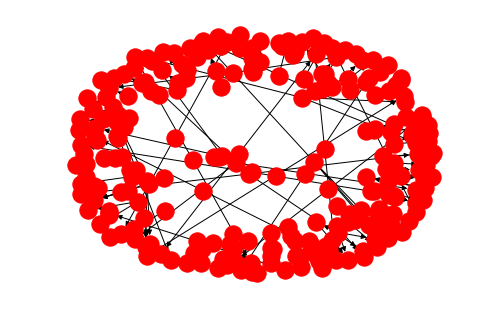

In [213]:
nx.draw(dG)

## Find and print cycles

In [215]:
cycles = list(nx.simple_cycles(dG))

In [216]:
for cycle in cycles:
    print(cycle)
    for i in range(len(cycle)-1):
        tup = (cycle[i],cycle[i+1])
        tup_back = (cycle[i+1],cycle[i])
        print(reaction_map[tup],"--",reaction_map[tup_back])

[3561, 2861]
nitro reduction -- n-oxidation
[2852, 3399]
n-oxidation -- nitro reduction
[3310, 2567]
nitro reduction -- n-oxidation
[2572, 3279]
n-oxidation -- nitro reduction
[3274, 3278]
n-oxidation -- nitro reduction
[3004, 3271]
n-oxidation -- nitro reduction
[3396, 645]
nitro reduction -- n-oxidation
[298, 299]
acetylation -- amide hydrolysis
[3005, 3254]
n-oxidation -- nitro reduction
[3242, 3244]
acetylation -- ester cleavage
[2666, 2668]
sulfur reduction -- sulphoxidation
[248, 179]
amide hydrolysis -- acetylation
[181, 247]
acetylation -- amide hydrolysis
[185, 249]
acetylation -- amide hydrolysis


## Find connected components with >= 4 nodes

In [220]:
components = list(nx.connected_components(G))
for i,c in enumerate(components):
    if len(c) >= 4:
        print(i,c,len(c))

1 {236, 845, 1038, 2708, 702} 5
6 {265, 67, 268, 502} 4
7 {288, 668, 132, 133, 262, 142, 277, 309, 2741, 3034, 667, 279, 157, 670, 287} 15
8 {672, 302, 283, 306, 346, 347, 284, 671} 8
9 {304, 52, 285, 286} 4
13 {2666, 2667, 2668, 2669} 4
14 {169, 697, 172, 2670} 4
15 {128, 124, 125, 126} 4
39 {992, 194, 916, 2701} 4
40 {2657, 2658, 3396, 645, 1034, 1053} 6
44 {2794, 2795, 2804, 2774, 2583} 5
45 {166, 2791, 2798, 3184, 2899, 2900} 6
50 {3281, 3275, 3461, 2822} 4
51 {3310, 3565, 3398, 2567} 4
58 {3121, 3106, 2845, 2862} 4
60 {3084, 2772, 3381, 3380, 3383, 3476} 6
76 {3066, 2739, 3604, 2934} 4


Plot the connected network

{(128, 126): Text(0.553326,-0.184925,'urea derivative'),
 (124, 125): Text(-0.553326,0.184925,'multiple'),
 (128, 125): Text(-0.346065,-0.0167226,'multiple')}

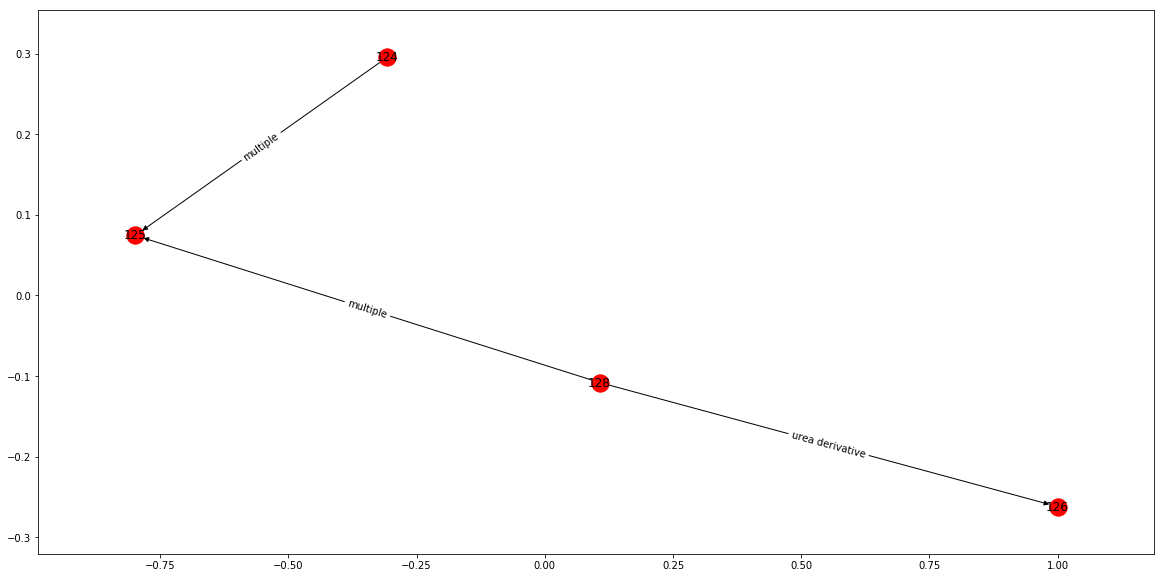

In [230]:
c_id = 15
sub = dG.subgraph(components[c_id])
pos = nx.spring_layout(sub)
plt.figure(figsize=(20,10))
ax = plt.gca()
pp = nx.draw_networkx(sub,pos = pos,ax = ax)
sub_reaction_map = {}
for (n1,n2),label in reaction_map.items():
    if n1 in components[c_id] and n2 in components[c_id]:
        sub_reaction_map[(n1,n2)] = label
nx.draw_networkx_edge_labels(sub,pos = pos,edge_labels = sub_reaction_map,font_size=10)